# 뉴스 카테고리 다중분류 프로젝트

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


## 함수 정의

In [2]:
def decode_to_text( text ) :
    decoded_text = []
    for i in range(len( text)):
        t = ' '.join([index_to_word[index] for index in text[i]])
        decoded_text.append(t)
    
    return decoded_text

## word_num별로 train, test를 가져오고, 단어장을 생성하는 함수
def load_reuters_by_vocab_sizes(vocab_sizes):
    data_by_vocab = {}

    # DTM 및 TF-IDF 설정
    dtmvector = CountVectorizer()
    tfidf_transformer = TfidfTransformer()

    # Keras Reuters OOV 토큰 인덱스 (기본값)
    OOV_CHAR = 2

    for size in vocab_sizes:
        # 1) 데이터 로드
        (x_train, y_train), (x_test, y_test) = reuters.load_data(
            num_words=size, test_split=0.2
        )

        # 2) 전체 토큰 및 OOV 비율 계산
        all_tokens = [tok for seq in list(x_train) + list(x_test) for tok in seq]
        total_tokens = len(all_tokens)
        token_counter = Counter(all_tokens)
        oov_count = token_counter.get(OOV_CHAR, 0)
        oov_rate = oov_count / total_tokens
        coverage = 1.0 - oov_rate

        # 3) 텍스트 디코딩
        decoded_train = decode_to_text(x_train)
        decoded_test  = decode_to_text(x_test)

        # 4) DTM 변환
        dtm_train = dtmvector.fit_transform(decoded_train)
        dtm_test  = dtmvector.transform(decoded_test)

        # 5) TF-IDF 변환
        tfidfv_train = tfidf_transformer.fit_transform(dtm_train)
        tfidfv_test  = tfidf_transformer.transform(dtm_test)

        # 6) 결과 저장
        data_by_vocab[size] = {
            'x_train': x_train,
            'y_train': y_train,
            'x_test':  x_test,
            'y_test':  y_test,
            'decoded_train': decoded_train,
            'decoded_test':  decoded_test,
            'tfidfv_train':  tfidfv_train,
            'tfidfv_test':   tfidfv_test,
            'coverage':      coverage,
            'oov_rate':      oov_rate
        }

    return data_by_vocab

def summarize_data_structure(data_by_vocab):
    """
    data_by_vocab의 구조를 요약해서 자동으로 출력하는 함수.
    각 vocab_size에 대해 훈련 데이터와 테스트 데이터의 크기 및 희소 행렬의 형태를 출력합니다.
    """
    for vocab_size, data in data_by_vocab.items():
        print(f"Vocab Size: {vocab_size}")
        
        # 훈련 데이터 크기
        train_data = data.get('tfidfv_train', None)
        if train_data is not None:
            print(f"  - 훈련 데이터 크기 (행, 열): {train_data.shape}")
            print(f"  - 훈련 데이터 문서 수: {train_data.shape[0]}")
        
        # 테스트 데이터 크기
        test_data = data.get('tfidfv_test', None)
        if test_data is not None:
            print(f"  - 테스트 데이터 크기 (행, 열): {test_data.shape}")
            print(f"  - 테스트 데이터 문서 수: {test_data.shape[0]}")
        
        print("-" * 40)

# 

# 실험 수행 함수
def RunClassifier(models, data_by_vocab, test_results):
    for model in models:
        model_name = model.__class__.__name__
        
        for vocab_size, data in data_by_vocab.items():
            print(f"== Model: {model_name}, Vocab Size: {vocab_size}")
            
            X_train = data.get('tfidfv_train')
            X_test  = data.get('tfidfv_test')
            y_train = data.get('y_train')
            y_test  = data.get('y_test')
            coverage = data.get('coverage')      # 전체 토큰 대비 커버리지 비율
            oov_rate = data.get('oov_rate')      # OOV 토큰 비율
            
            if X_train is None or X_test is None:
                continue
            
            # 1) 학습 시간 측정
            start_train = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start_train
            
            # 2) 예측 시간 측정
            start_pred = time.time()
            y_pred = model.predict(X_test)
            pred_time = time.time() - start_pred
            
            # 3) 전체 시간
            total_time = train_time + pred_time
            
            # 4) 성능 지표 계산
            acc = accuracy_score(y_test, y_pred)
            cr = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
            precision = cr['weighted avg']['precision']
            recall    = cr['weighted avg']['recall']
            f1        = cr['weighted avg']['f1-score']
            cm = confusion_matrix(y_test, y_pred)
            
            print(f"   Accuracy: {acc:.5f}")
            print(f"   Precision: {precision:.5f}, Recall: {recall:.5f}, F1: {f1:.5f}")
            print(f"   Train time: {train_time:.2f}s, Predict time: {pred_time:.2f}s, Total time: {total_time:.2f}s")
            print(f"   Coverage: {coverage:.2%}, OOV rate: {oov_rate:.2%}")
            print(f"   Confusion matrix:\n{cm}")
            
            # 5) 결과 저장
            test_results.append({
                'model': model_name,
                'vocab_size': vocab_size,
                'accuracy': round(acc, 4),
                'precision': round(precision, 4),
                'recall': round(recall, 4),
                'f1_score': round(f1, 4),
                'train_time': round(train_time, 2),
                'pred_time': round(pred_time, 2),
                'total_time': round(total_time, 2),
                'coverage': round(coverage, 4),
                'oov_rate': round(oov_rate, 4),
                'confusion_matrix': cm.tolist()
            })

            
            
            

## 모델 정의

In [3]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 1. 나이브 베이즈 분류기
mnb = MultinomialNB()

# 2. ComplementNB
cnb = ComplementNB()

# 3. 로지스틱 회귀(Logistic Regression)
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)

# 4. 선형 서포트 벡터 머신(Linear Support Vector Machine)
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)

# 5. 결정 트리(Decision Tree)
tree = DecisionTreeClassifier(max_depth=10, random_state=0)

# 6. 랜덤 포레스트(Random Forest)
forest = RandomForestClassifier(n_estimators=5, random_state=0)

# 7. 그래디언트 부스팅 트리(GradientBoostingClassifier)
grbt = GradientBoostingClassifier(random_state=0) # verbose=3

# 8. Voting
# 개별 모델 정의
log_clf = LogisticRegression(penalty='l2', solver='liblinear')  # L2 기본값이지만 명시함
nb_clf = ComplementNB()
gb_clf = GradientBoostingClassifier()

# VotingClassifier 정의 (soft voting)
voting_classifier = VotingClassifier(
    estimators=[('lr', log_clf), ('nb', nb_clf), ('gb', gb_clf)],
    voting='soft'
)


## 데이터 확인

- 뉴스 길이가 정규분포가 아니고 길이가 작은쪽으로 치우쳐져 있음을 알 수 있다
- 클래스간 불균형이 심함 -> accuracy 뿐 아니라 f1 확인 필요
- 고유 토큰의 분포와 빈도를 확인한 결과 상위 5000개 토큰으로 문서의 93%가 커버된다.
- 상위 토큰의 문서의 차지 비중을 그래프로 그려보니 log 곡선 형태로 증가 -> 테스트 vocabsize 결정시 로그스케일 단위 고려

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


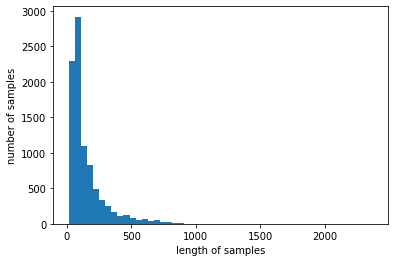

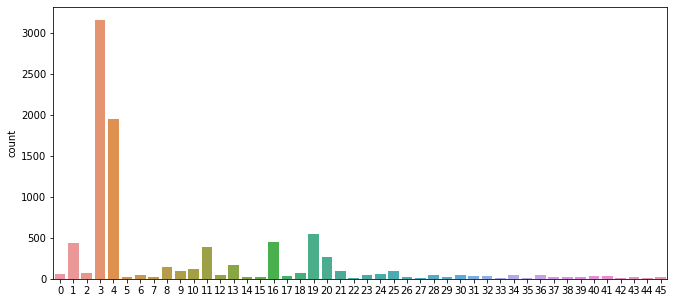

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [4]:

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

전체 고유 토큰 수 (vocab size): 30980

상위 10개 토큰과 빈도수:
토큰 the: 82723회
토큰 of: 42393회
토큰 to: 40350회
토큰 in: 33157회
토큰 said: 29978회

하위 10개 토큰과 빈도수:
토큰 amstutz': 1회
토큰 kandeel: 1회
토큰 mena: 1회
토큰 0500: 1회
토큰 chalna: 1회

빈도가 1회 이하인 토큰 수: 10308

전체 토큰 1638886, 상위 5000개 토큰 1530903
상위 5000개 토큰이 전체에서 차지하는 비중: 93.41%

Top 100 tokens coverage: 48.23%
Top 500 tokens coverage: 69.18%
Top 1000 tokens coverage: 78.31%
Top 2000 tokens coverage: 85.96%
Top 5000 tokens coverage: 93.41%
Top 10000 tokens coverage: 97.26%
Top 20000 tokens coverage: 99.29%
Top 30000 tokens coverage: 99.94%


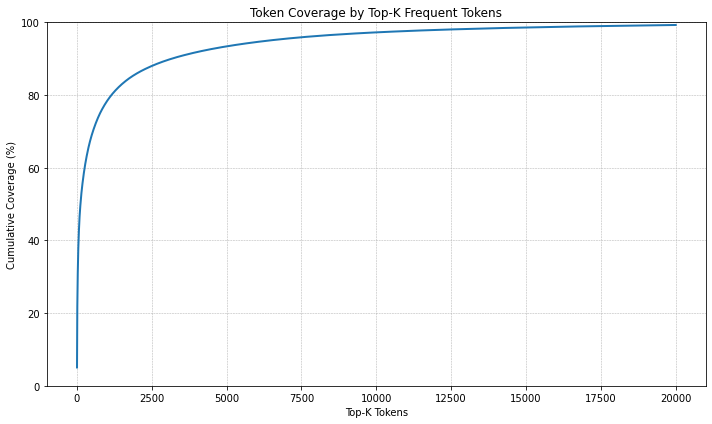

In [5]:
# word index
word_index = reuters.get_word_index(path="reuters_word_index.json")

#<pad>, <sos>, <unk>
index_to_word = { index+3 : word for word, index in word_index.items() }

# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token



# 훈련+테스트 시퀀스 합치기
all_seqs = list(x_train) + list(x_test)

# 전체 vocab size 계산
unique_tokens = set(token for seq in all_seqs for token in seq)
vocab_size = len(unique_tokens)
print("전체 고유 토큰 수 (vocab size):", vocab_size)

# 토큰별 등장 빈도 계산
token_counter = Counter(token for seq in all_seqs for token in seq)
print("\n상위 10개 토큰과 빈도수:")
for token, cnt in token_counter.most_common(5):
    print(f"토큰 {index_to_word[token]}: {cnt}회")

print("\n하위 10개 토큰과 빈도수:")
for token, cnt in token_counter.most_common()[:-6:-1]:
    print(f"토큰 {index_to_word[token]}: {cnt}회")

low_freq_count = sum(1 for count in token_counter.values() if count <= 1)
print(f"\n빈도가 1회 이하인 토큰 수: {low_freq_count}")

# 전체 토큰 수
total_tokens = sum(token_counter.values())

# 상위 5000개 토큰의 빈도 합
top_5000_count = sum(count for _, count in token_counter.most_common(5000))

# 비중 계산 및 출력
coverage_ratio = top_5000_count / total_tokens
print(f"\n전체 토큰 {total_tokens}, 상위 5000개 토큰 {top_5000_count}")
print(f"상위 5000개 토큰이 전체에서 차지하는 비중: {coverage_ratio:.2%}\n")


# 빈도별 토큰 수 계산 (frequency of frequencies)
freq_of_freq = Counter(token_counter.values())

# 빈도 내림차순으로 정렬한 리스트
freqs_sorted = np.array(sorted(token_counter.values(), reverse=True))

# 누적 합 및 커버리지 계산
cum_counts = np.cumsum(freqs_sorted)
coverage = cum_counts / total_tokens

# 특정 Top-K 목록에서 커버리지 출력
k_list = [100, 500, 1000, 2000, 5000, 10000, 20000, 30000]
for k in k_list:
    print(f"Top {k} tokens coverage: {coverage[k-1]:.2%}")


# 시각화 (직관적 선형 스케일)
k_max = 20000
x = np.arange(1, k_max + 1)
y = coverage[:k_max]

plt.figure(figsize=(10, 6))
plt.plot(x, y * 100, linewidth=2)  # % 단위로 변환
plt.xlabel('Top-K Tokens')
plt.ylabel('Cumulative Coverage (%)')
plt.title('Token Coverage by Top-K Frequent Tokens')
plt.ylim(0, 100)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Vocab Size별 데이타 로딩 및 단어장 구성
- 데이터 분석 결과를 바탕으로 100, 1000, 10000 의 크기별 모델 실험 진행

In [7]:
vocab_sizes = [100,1000,10000]
data_by_vocab = load_reuters_by_vocab_sizes(vocab_sizes)

In [8]:
print(data_by_vocab.keys())


summarize_data_structure(data_by_vocab)

dict_keys([100, 1000, 10000])
Vocab Size: 100
  - 훈련 데이터 크기 (행, 열): (8982, 85)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 85)
  - 테스트 데이터 문서 수: 2246
----------------------------------------
Vocab Size: 1000
  - 훈련 데이터 크기 (행, 열): (8982, 969)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 969)
  - 테스트 데이터 문서 수: 2246
----------------------------------------
Vocab Size: 10000
  - 훈련 데이터 크기 (행, 열): (8982, 9670)
  - 훈련 데이터 문서 수: 8982
  - 테스트 데이터 크기 (행, 열): (2246, 9670)
  - 테스트 데이터 문서 수: 2246
----------------------------------------


## 모델 구성
- 실험을 팀원들과 모델을 구분하여 진행
- 담당 모델 : 나이즈베이즈 분류기, 로지스틱 회귀

In [9]:
models_1 = [mnb, lr]


## 모델 실험

In [11]:
test_results = []
RunClassifier( models_1 , data_by_vocab, test_results )

== Model: MultinomialNB, Vocab Size: 100
   Accuracy: 0.49777
   Precision: 0.41706, Recall: 0.49777, F1: 0.40875
   Train time: 0.01s, Predict time: 0.00s, Total time: 0.01s
   Coverage: 47.88%, OOV rate: 52.12%
   Confusion matrix:
[[0 1 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
== Model: MultinomialNB, Vocab Size: 1000
   Accuracy: 0.68566
   Precision: 0.65649, Recall: 0.68566, F1: 0.63650
   Train time: 0.02s, Predict time: 0.00s, Total time: 0.02s
   Coverage: 78.27%, OOV rate: 21.73%
   Confusion matrix:
[[ 3  3  0 ...  0  0  0]
 [ 0 80  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
== Model: MultinomialNB, Vocab Size: 10000
   Accuracy: 0.65672
   Precision: 0.59242, Recall: 0.65672, F1: 0.57645
   Train time: 0.04s, Predict time: 0.01s, Total time: 0.04s
   Coverage: 97.26%, OOV rate: 2.74%
   Confusion matrix:
[[ 0  3  0 ...  0  0

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   Accuracy: 0.67898
   Precision: 0.66307, Recall: 0.67898, F1: 0.66709
   Train time: 72.57s, Predict time: 0.00s, Total time: 72.57s
   Coverage: 47.88%, OOV rate: 52.12%
   Confusion matrix:
[[ 4  0  0 ...  0  0  0]
 [ 0 43  2 ...  0  0  1]
 [ 0  2  4 ...  1  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  0]]
== Model: LogisticRegression, Vocab Size: 1000
   Accuracy: 0.73865
   Precision: 0.73763, Recall: 0.73865, F1: 0.73256
   Train time: 367.06s, Predict time: 0.01s, Total time: 367.07s
   Coverage: 78.27%, OOV rate: 21.73%
   Confusion matrix:
[[ 8  1  0 ...  0  0  0]
 [ 0 74  1 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]
== Model: LogisticRegression, Vocab Size: 10000
   Accuracy: 0.81077
   Precision: 0.81186, Recall: 0.81077, F1: 0.80568
   Train time: 545.53s, Predict time: 0.02s, Total time: 545.54s
   Coverage: 97.26%, OOV rate: 2.74%
   Confusion matrix:
[[ 8 

In [12]:
# 결과 출력
for result in test_results:
    print(result)

{'model': 'MultinomialNB', 'vocab_size': 100, 'accuracy': 0.4978, 'precision': 0.4171, 'recall': 0.4978, 'f1_score': 0.4088, 'train_time': 0.01, 'pred_time': 0.0, 'total_time': 0.01, 'coverage': 0.4788, 'oov_rate': 0.5212, 'confusion_matrix': [[0, 1, 0, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 6, 0, 7, 91, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 648, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 11, 463, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [15]:
test_results_ori = test_results.copy()

## 추가 실험 준비 ( 딥러닝 모델 )

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
import time
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow.keras.backend as K
from sklearn.base import clone
def RunDLClassifier(models, data_by_vocab, test_results,
                    max_len=800, embedding_dim=128):
    for build_fn in models:  # models: list of callables that build a fresh model given vocab_size
        model_name = build_fn.__name__
        
        for vocab_size, data in data_by_vocab.items():
            print(f"== DL Model: {model_name}, Vocab Size: {vocab_size}")

            # 1) 이전 그래프·세션 클리어
            K.clear_session()
            
            # 원본 시퀀스와 레이블
            x_train_seq = data['x_train']
            x_test_seq  = data['x_test']
            y_train     = data['y_train']
            y_test      = data['y_test']
            coverage    = data.get('coverage', None)
            oov_rate    = data.get('oov_rate', None)
            
            # 1) 시퀀스 패딩
            X_train = pad_sequences(x_train_seq, maxlen=max_len, padding='pre')
            X_test  = pad_sequences(x_test_seq,  maxlen=max_len, padding='pre')
            
            # 2) 모델 생성
            model = build_fn(vocab_size, max_len, embedding_dim)
            model.compile(
                loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=[]
            )
            
            # 3) 학습 시간 측정
            start_train = time.time()
            model.fit(
                X_train, y_train,
                epochs=5, batch_size=128, verbose=0,
                validation_split=0.1
            )
            train_time = time.time() - start_train
            
            # 4) 예측 시간 측정
            start_pred = time.time()
            y_pred_prob = model.predict(X_test, verbose=0)
            pred_time = time.time() - start_pred
            
            # 5) 가장 높은 확률의 클래스 선택
            y_pred = np.argmax(y_pred_prob, axis=1)
            total_time = train_time + pred_time
            
            # 6) 성능 지표 계산
            acc = accuracy_score(y_test, y_pred)
            cr = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
            precision = cr['weighted avg']['precision']
            recall    = cr['weighted avg']['recall']
            f1        = cr['weighted avg']['f1-score']
            cm        = confusion_matrix(y_test, y_pred)
            
            # 7) 결과 출력
            print(f"   Accuracy: {acc:.5f}")
            print(f"   Precision: {precision:.5f}, Recall: {recall:.5f}, F1: {f1:.5f}")
            print(f"   Train time: {train_time:.2f}s, Predict time: {pred_time:.2f}s, Total time: {total_time:.2f}s")
            if coverage is not None and oov_rate is not None:
                print(f"   Coverage: {coverage:.2%}, OOV rate: {oov_rate:.2%}")
            print(f"   Confusion matrix:\n{cm}")
            
            # 8) 결과 저장
            test_results.append({
                'model': model_name,
                'vocab_size': vocab_size,
                'accuracy': round(acc, 4),
                'precision': round(precision, 4),
                'recall': round(recall, 4),
                'f1_score': round(f1, 4),
                'train_time': round(train_time, 2),
                'pred_time': round(pred_time, 2),
                'total_time': round(total_time, 2),
                'coverage': round(coverage, 4) if coverage is not None else None,
                'oov_rate': round(oov_rate, 4) if oov_rate is not None else None,
                'confusion_matrix': cm.tolist()
            })
            
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout


def build_cnn_text_classifier(vocab_size, max_len, embedding_dim=128, 
                              num_filters=128, kernel_size=5, dropout_rate=0.5, num_classes=46):
    """
    1D CNN 기반 텍스트 분류 모델 빌더
    - Embedding → Conv1D → GlobalMaxPooling1D → Dense → Dropout → Dense
    """
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='valid'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

## 추가 실험 진행 ( 1D CNN ) 

In [29]:
test_results = test_results_ori.copy()
models_dl = [build_cnn_text_classifier]
RunDLClassifier( models_dl , data_by_vocab, test_results )

== DL Model: build_cnn_text_classifier, Vocab Size: 100
   Accuracy: 0.64426
   Precision: 0.55293, Recall: 0.64426, F1: 0.58437
   Train time: 7.60s, Predict time: 0.20s, Total time: 7.80s
   Coverage: 47.88%, OOV rate: 52.12%
   Confusion matrix:
[[ 0  4  0 ...  0  0  0]
 [ 0 59  0 ...  0  0  0]
 [ 0  4  0 ...  0  0  0]
 ...
 [ 0  2  0 ...  0  0  0]
 [ 0  5  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]]
== DL Model: build_cnn_text_classifier, Vocab Size: 1000
   Accuracy: 0.72484
   Precision: 0.63545, Recall: 0.72484, F1: 0.66986
   Train time: 7.62s, Predict time: 0.20s, Total time: 7.82s
   Coverage: 78.27%, OOV rate: 21.73%
   Confusion matrix:
[[ 0  2  0 ...  0  0  0]
 [ 0 86  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 ...
 [ 0  1  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
== DL Model: build_cnn_text_classifier, Vocab Size: 10000
   Accuracy: 0.73019
   Precision: 0.67082, Recall: 0.73019, F1: 0.67873
   Train time: 7.90s, Predict time: 0.21s, Total time: 8.1

## 실험 결과 ( 개인 결과 )

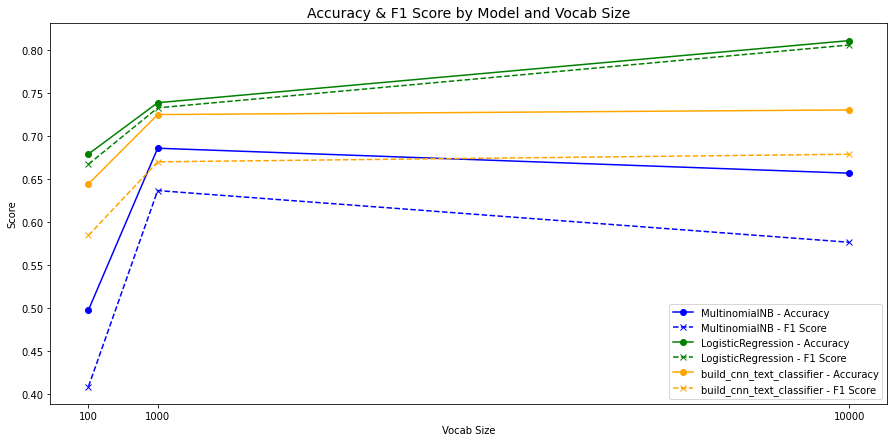

In [33]:


# DataFrame 변환
df = pd.DataFrame(test_results)

# vocab_size가 None 또는 NaN인 경우 20000으로 치환
df['vocab_size_for_plot'] = df['vocab_size'].apply(
    lambda x: 20000 if pd.isna(x) else int(x)
)

# 그래프 그리기
#plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15, 7))

# 색상 지정 (모델 수만큼 색 준비)
colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan','yellow']
model_names = df['model'].unique()
color_map = {model: colors[i % len(colors)] for i, model in enumerate(model_names)}

# 모델별 plot
for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name]
    color = color_map[model_name]
    
    ax.plot(model_df['vocab_size_for_plot'], model_df['accuracy'], 
            marker='o', color=color, label=f'{model_name} - Accuracy')
    ax.plot(model_df['vocab_size_for_plot'], model_df['f1_score'], 
            marker='x', color=color, linestyle='--', label=f'{model_name} - F1 Score')

# 레이블, 타이틀 등 설정
ax.set_title('Accuracy & F1 Score by Model and Vocab Size', fontsize=14)
ax.set_xlabel('Vocab Size')
ax.set_ylabel('Score')
ax.legend()
# x축 눈금 강제 지정
xticks = sorted(df['vocab_size_for_plot'].unique())
ax.set_xticks(xticks)

#plt.grid(True)
plt.show()

## 실험 결과 ( 팀 실험 결과 전체 )
### 결과표


In [18]:
df = pd.read_csv("./team_m2_result_reuters_classifiaction0513.csv")

df

,model,vocabsize,accuracy,f1,time(s)
0,랜덤 포레스트,100,0.63802,0.61571,0.68
1,랜덤 포레스트,1000,0.70748,0.68285,0.96
2,랜덤 포레스트,10000,0.67409,0.64295,1.64
3,서포트 벡터 머신,100,0.67050,0.64510,170.21
4,서포트 벡터 머신,1000,0.71990,0.71650,156.07
5,서포트 벡터 머신,10000,0.78360,0.78060,112.21
6,보팅,100,0.65090,0.64090,347.26
7,보팅,1000,0.76270,0.75360,698.55
8,보팅,10000,0.79030,0.78660,911.16
9,로지스틱 회귀,100,0.67898,0.66709,72.57


### Accurucy & f1

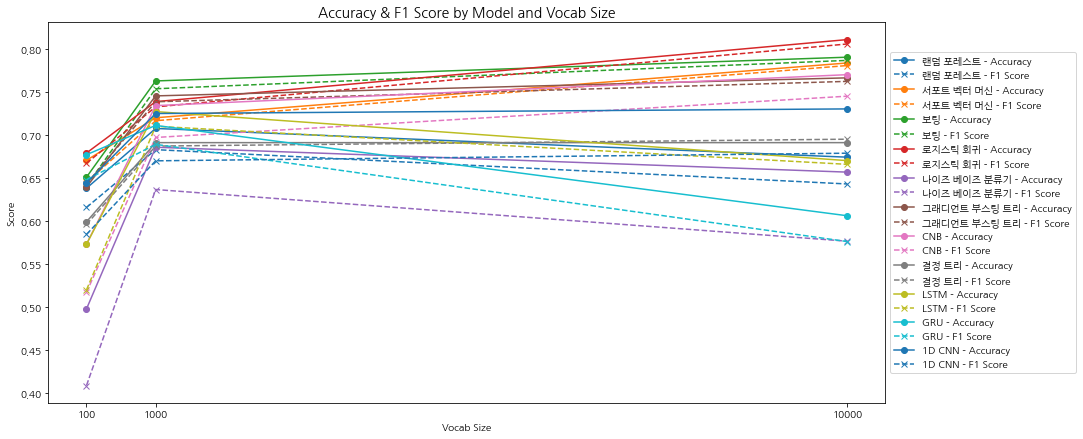

In [19]:
import matplotlib as mpl
mpl.rc('font', family='NanumGothic')        # 한글 폰트 이름으로 변경
mpl.rc('axes', unicode_minus=False)         # 마이너스 기호 깨짐 방지

# 그래프 그리기
#plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15, 7))

colors = plt.get_cmap('tab10').colors

color_idx = 0

# 모델별 plot
for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name]
    color = colors[color_idx % len(colors)]
    color_idx = color_idx+1
    
    ax.plot(model_df['vocabsize'], model_df['accuracy'], 
            marker='o', color=color, label=f'{model_name} - Accuracy')
    ax.plot(model_df['vocabsize'], model_df['f1'], 
            marker='x', color=color, linestyle='--', label=f'{model_name} - F1 Score')

# 레이블, 타이틀 등 설정
ax.set_title('Accuracy & F1 Score by Model and Vocab Size', fontsize=14)
ax.set_xlabel('Vocab Size')
ax.set_ylabel('Score')
ax.legend()
# x축 눈금 강제 지정
xticks = sorted(df['vocabsize'].unique())
ax.set_xticks(xticks)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))    # 범례를 우측으로

#plt.grid(True)
plt.show()

### Accuracy

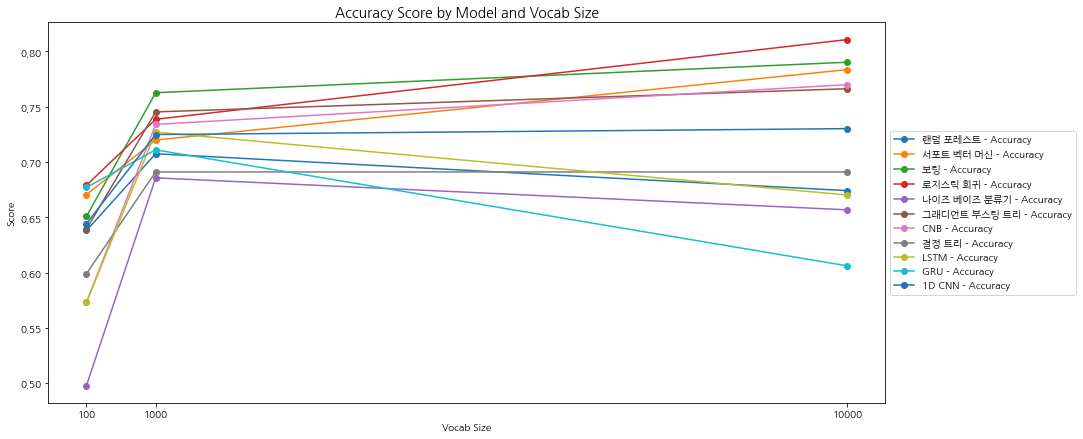

In [23]:

# 그래프 그리기
#plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15, 7))

colors = plt.get_cmap('tab10').colors

color_idx = 0

# 모델별 plot
for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name]
    color = colors[color_idx % len(colors)]
    color_idx = color_idx+1
    
    ax.plot(model_df['vocabsize'], model_df['accuracy'], 
            marker='o', color=color, label=f'{model_name} - Accuracy')


# 레이블, 타이틀 등 설정
ax.set_title('Accuracy Score by Model and Vocab Size', fontsize=14)
ax.set_xlabel('Vocab Size')
ax.set_ylabel('Score')
ax.legend()
# x축 눈금 강제 지정
xticks = sorted(df['vocabsize'].unique())
ax.set_xticks(xticks)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))    # 범례를 우측으로

#plt.grid(True)
plt.show()

### F1

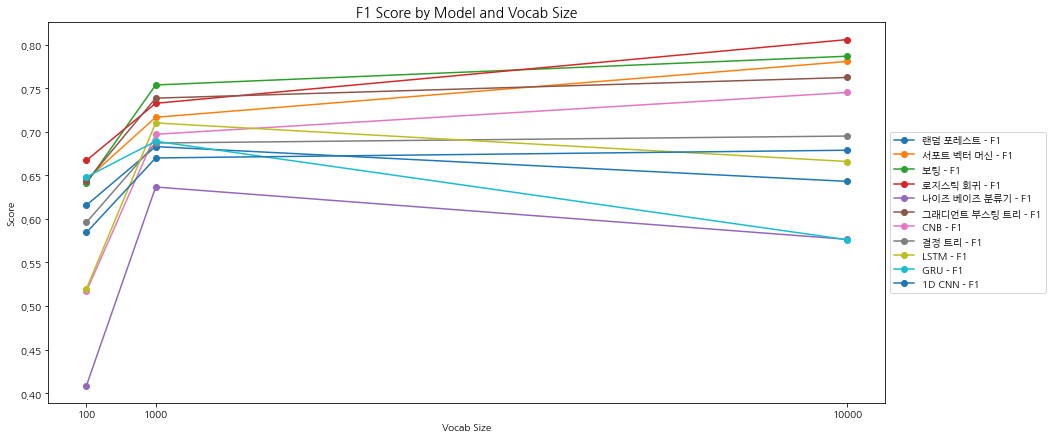

In [24]:

# 그래프 그리기
#plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15, 7))

colors = plt.get_cmap('tab10').colors

color_idx = 0

# 모델별 plot
for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name]
    color = colors[color_idx % len(colors)]
    color_idx = color_idx+1
    
    ax.plot(model_df['vocabsize'], model_df['f1'], 
            marker='o', color=color, label=f'{model_name} - F1')


# 레이블, 타이틀 등 설정
ax.set_title('F1 Score by Model and Vocab Size', fontsize=14)
ax.set_xlabel('Vocab Size')
ax.set_ylabel('Score')
ax.legend()
# x축 눈금 강제 지정
xticks = sorted(df['vocabsize'].unique())
ax.set_xticks(xticks)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))    # 범례를 우측으로

#plt.grid(True)
plt.show()

### 학습 및 예측 시간

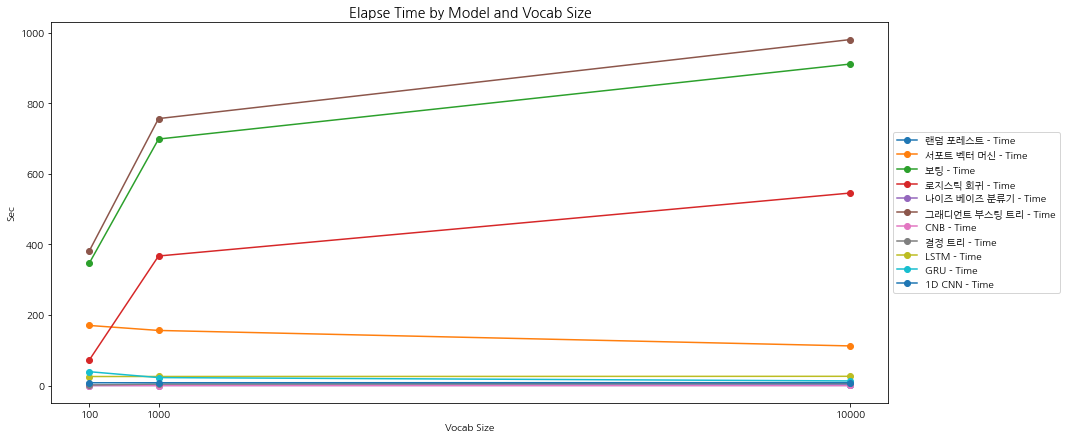

In [28]:
# 그래프 그리기
#plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(15, 7))

colors = plt.get_cmap('tab10').colors

color_idx = 0

# 모델별 plot
for model_name in df['model'].unique():
    model_df = df[df['model'] == model_name]
    color = colors[color_idx % len(colors)]
    color_idx = color_idx+1
    
    ax.plot(model_df['vocabsize'], model_df['time(s)'], 
            marker='o', color=color, label=f'{model_name} - Time')


# 레이블, 타이틀 등 설정
ax.set_title('Elapse Time by Model and Vocab Size', fontsize=14)
ax.set_xlabel('Vocab Size')
ax.set_ylabel('Sec')
ax.legend()
# x축 눈금 강제 지정
xticks = sorted(df['vocabsize'].unique())
ax.set_xticks(xticks)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))    # 범례를 우측으로

#plt.grid(True)
plt.show()

## 결과 정리

- 성능 기반 최고 모델 : 로지스틱 회귀 (LR)
  학습 시간이 오래 걸리지만 테스트에서 가장 좋은 성능을 보인 것은 로지스틱 회귀이다. 희소 특성에 강하며 데이터가 늘어날 수록 성능이 좋아지는 것을 확인 할 수 있다. vocab이 좀 더 커졌을 경우와 다른 모델들의 하이퍼파라미터가 최적화되었을 경우 결과가 달라질 수 있다. SVM은 일반적으로 최고의 성능을 내는 것으로 알려져 있는데 이 문제의 특성과 vocabsize 기준으로 인해 LR 의 성능이 가장 잘 나온 것으로 보인다.  

- 학습 속도를 고려해야 한다면  ComplementNB나 SVM을 고려해 볼 수 있다.   
 ComplementNB  vocab 10 000: Accuracy 0.770, F1 0.745, time 0.04 s   
 SVM vocab 10 000: Accuracy 0.784, F1 0.781, time 112 s   
 
- vocabsize 에 따른 성능 변화는 100에서 1000으로 변화시는 항상 향상되나 1000에서 10000으로 변화시는 일부 모델은 성능 저하가 일어난다.   
 ( vocab이 문서의 80%정도를 커버하면 성능이 나오는 것을 볼 수 있으나 그 이하에서는 급격히 성능 저하가 일어나는 것을 볼 수 있다)
- Vocab Size가 늘었을 때 성능이 줄어든 모델: 나이즈베이즈 분류기(NB), RandomForest(RF), GRU, LSTM   
 이는 희귀 단어들이 노이즈로 작용했을 가능성이 있다. NB와 RF의 경우 통계 기반 모델로 이런 잡음까지 학습해 성능이 떨어진 것으로 볼 수 있다.   
 vocab이 증가할 수록 DTM/TF-DIF 행렬의 대부분 셀이 0이 되는 희소 행렬로 딥러닝 모델들도 긴 임베딩 시퀀스에서 의미를 학습하기 어려워 질 가능성이 있다.   
 딥러닝 모델인 GRU 및 LSTM에 early stop이 잘못 적용되거나 충분한 epoch수를 훈련하지 못했을 가능성이 있다
 RF의 경우 n_estimators 등의 하이퍼 파라미터가 최적이 아닐 가능성을 배제할 수는 없다

- vocabsize 에 따라 대부분 학습 및 예측 시간이 증가하나 일부 모델의 경우 학습 시간이 줄어드는 경우가 있었다.
 SVM 의 경우 고차원의 경우 데이터가 선형적으로 분리될 가능성이 커진다고 한다. 내부 최적화 알고리즘에 의해 수렴조건이 빨리 만족되고 이로 인해 반복 횟수가 줄어들며 시간이 단축된다고 한다. (희소 행렬에서 0이 아닌 원소만 처리하는 최적화 기법등)
 GRU의 경우 early stop 적용으로 시간이 단축되었다. 희귀 단어가 많은 경우는 학습이 원활하지 않으므로 희긔 단어가 적어질 수록 학습이 원활해져 더 빠르게 손실이 감소해 epoch수가 줄어든 것으로 보인다. batch당 처리 시간이나 epoch당 속도는 큰 차이는 없는 것으로 보인다.

- 딥러닝 모델들이 성능이 좋게 나온 머신러닝 모델들보다 성능이 떨어졌다.
 성능이 좋은 머신러닝들의 학습 시간이 꽤 길어지므로 시간 대비로 봤을때는 딥러닝의 성능이 나쁘다 보기는 힘들다. 문제의 특성(문장길이가 짧음, 46개의 다중 클래스, 희소 단어 비중 높음)등으로 인해 통계 기반 방식이 유리했을 가능성이 있다. 그리고 추가로 딥러닝 하이퍼 파라미터가 제대로 최적화되지 않았을 가능성도 배제할 수 없다.
 
 

## 회고

뉴스 분류 문제로 문장길이가 짧음, 46개의 다중 클래스, 희귀 단어 비중이 높음 등의 특징이 있는 문제였다. 머신러닝 모델들을 나눠서 테스트 하고 결과를 취합해 분석을 하면서 왜 그럴까에 대해서 생각하고 검색하다 보니 많은 공부가 된것 같다. 예상과 다르게 나온 부분들 데이터가 많아지는데 성능이 낮아지는 것과 데이터가 늘었는데 학습 시간이 줄어든 것들이 인상적이었고 원인 분석하는 과정이 재밌었다. 그리고 vocabsize를 전체 문서 대비 매우 적었을때와 적정할때 그리고 필요 이상으로 많을때로 나눠지게 잡았는데 실험 결과가 어느정도 그에 맞게 나온것 같다. 다만 모델들의 최적점을 잡으려면 1000과 10000 사이를 세분화 테스트를 해 볼 필요가 있을 것으로 보인다. 그리고 실험을 진행하면서 test result에 값을 추가했는데 팀 베이스 코드에는 적용할 수 없어 해당 부분에 대한 결과를 통합적으로 비교해 볼 수 없어 아쉽다.(카테고리별 metric, CM등) 그리고 일부 실험 결과는 하이퍼파라미터에 의해 바뀔 수 있는 부분이 있어 이런 부분까지 확인해 볼 시간이 부족함이 아쉬웠다. 딥러닝 모델의 경우는 모델만 정하고 진행을해서 서로 하이퍼파라미터나 콜백을 다르게 적용한 부분이 있어 이런 변인 통제 부분이 아쉬웠다. 시간과 계획에서 아쉬움이 남지만 이런 경험이 앞으로의 다른 프로젝트나 실험에서 도움이 될 것으로 생각한다. 시간이 된다면 아쉬운 부분을 추가 실험해보면 좋을것 같다. 